In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

from segment_cell import *

## Define paths to train images

In [3]:
data = DataLoader('../data')
data.set_data('train')

  0%|▎                                                                                 | 1/294 [00:00<00:37,  7.88it/s]

Loading train data...


  0%|                                                                                           | 0/72 [00:00<?, ?it/s]

Loading test data...


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:05<00:00, 13.68it/s]


Open a random image and display it with its label

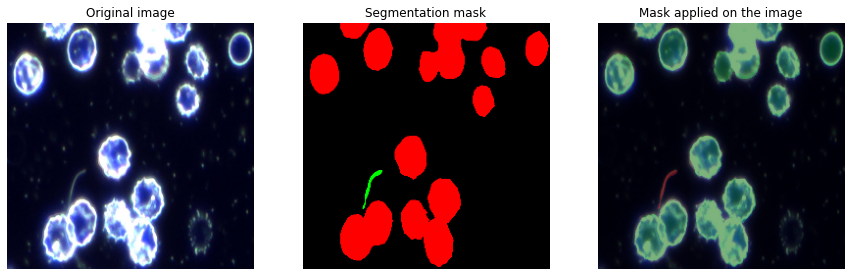

In [4]:
i = np.random.randint(0, len(data))
image, mask = data[i]

show_ann(image, mask)
plt.savefig('ex1.png', dpi=72)

# Step by step solution:

## 1. Get mask proposals

### 1.1. Use adaptative histogram equalization to highlight darker regions

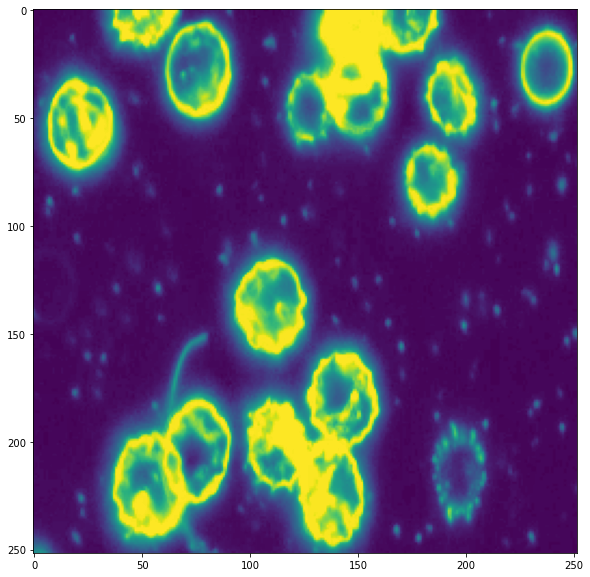

In [5]:
# define kernel
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# augment contrast of objects in scene
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
blur = equalize_adapthist(lab[...,0], clip_limit=0.01)
blur = np.uint8(blur*255)

plt.figure(figsize=(10,10))
plt.imshow(blur)

### 1.2. Use threshold OTSU to binary image

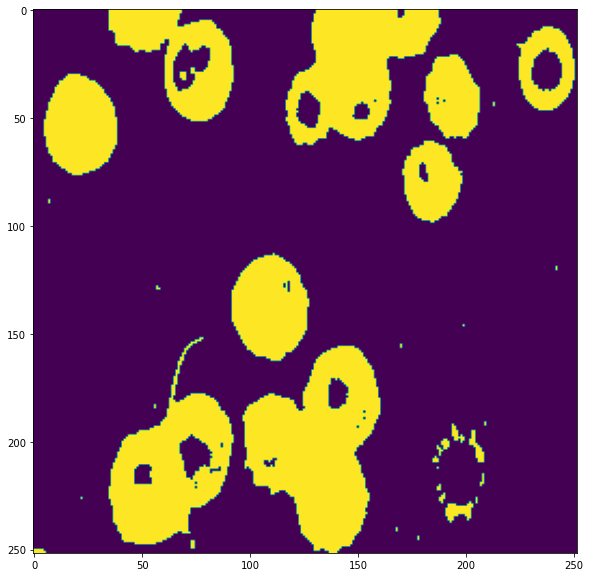

In [6]:
th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

plt.figure(figsize=(10,10))
plt.imshow(th)

### 1.3. Remove noises base on the contour features (perimeter<8)

Text(0.5, 1.0, 'After noise removal')

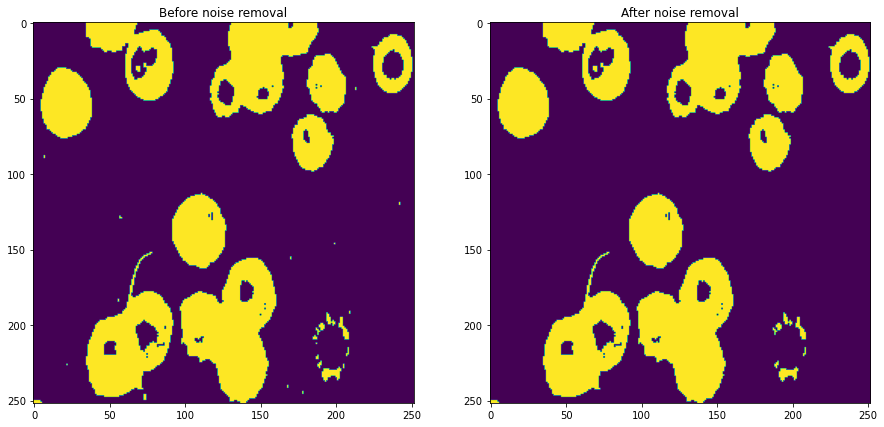

In [7]:
# remove noises
contour = cv2.findContours(th,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
segmented = np.copy(th)
for cnt in contour:
    perimeter = cv2.arcLength(cnt,True)
    if perimeter>8:
        continue

    # remove noise
    draw = np.ones_like(segmented)
    cv2.drawContours(draw, [cnt], 0, (0,0,0), -1)

    segmented = segmented * draw
mask = np.uint8(segmented)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(th)
plt.title('Before noise removal')
plt.subplot(122)
plt.imshow(mask)
plt.title('After noise removal')

### 1.4. Split thin regions

#### 1.4.1. Use a erosion and dilation subtraction to get to masks: (1) sure ery; (2) unknown

- (1) sure ery refers to segments more possible to be from ery class
- (2) unknown refers to segments that are unknown to which class it refers to

Text(0.5, 1.0, 'unknown')

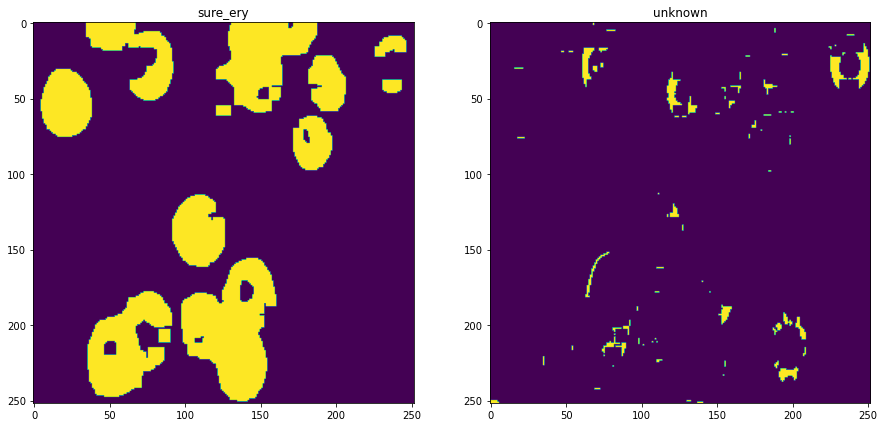

In [8]:
# split possible ery x spi classes
kernel = np.ones((3,3),np.uint8)
unknown = cv2.erode(mask, kernel, iterations=3)
sure_ery = cv2.dilate(unknown, kernel, iterations=3)
    
# unknown labels
unknown = cv2.subtract(mask, sure_ery)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(sure_ery)
plt.title('sure_ery')

plt.subplot(122)
plt.imshow(unknown)
plt.title('unknown')

#### 1.4.2. Remove noises from the unknown regions mask

Text(0.5, 1.0, 'After noise removal')

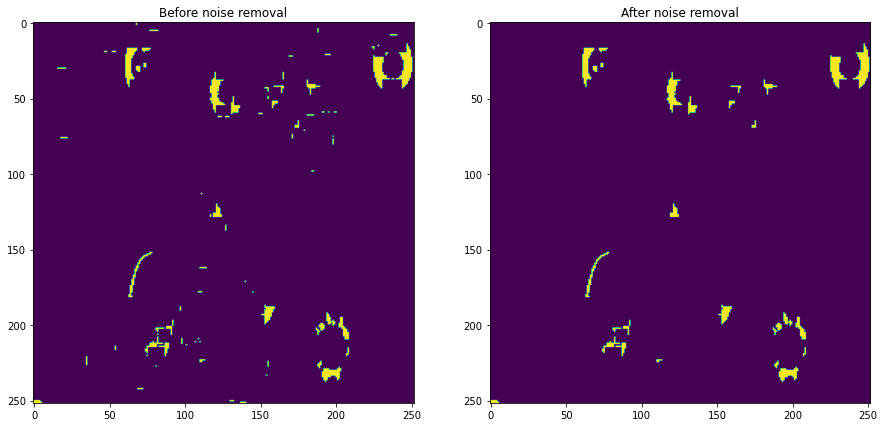

In [9]:
# probably spi
contour = cv2.findContours(unknown, cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)[1]
spi = np.zeros_like(sure_ery)
for cnt in contour:

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
    if area<1 or perimeter<1:
        continue

    _ = cv2.drawContours(spi, [cnt], 0, 255, -1)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(unknown)
plt.title('Before noise removal')
plt.subplot(122)
plt.imshow(spi)
plt.title('After noise removal')

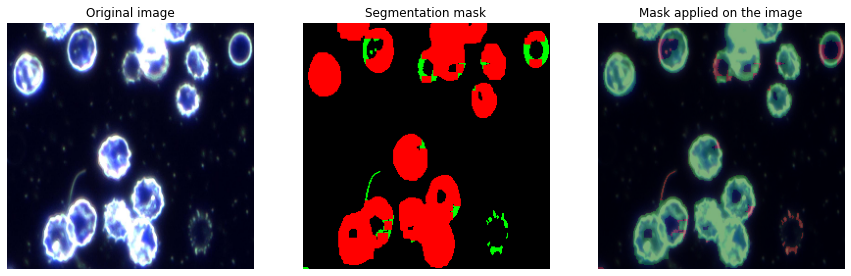

In [10]:
y_pred = get_mask_proposal(image)
show_ann(image, np.stack(y_pred, axis=-1))

## 2. Extract features from the masks

Using the Histogram of Oriented Gradients (HOG) to extract features from each mask.

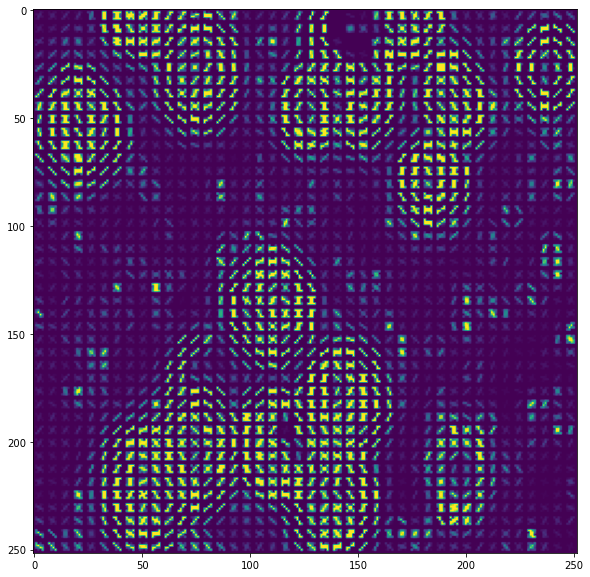

In [11]:
feats, hog_image = hog(image, orientations=8, pixels_per_cell=(6,6), 
                       cells_per_block=(1,1), visualize=True, multichannel=True)

# rescale histogram for better display
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize=(10,10))
plt.imshow(hog_image)

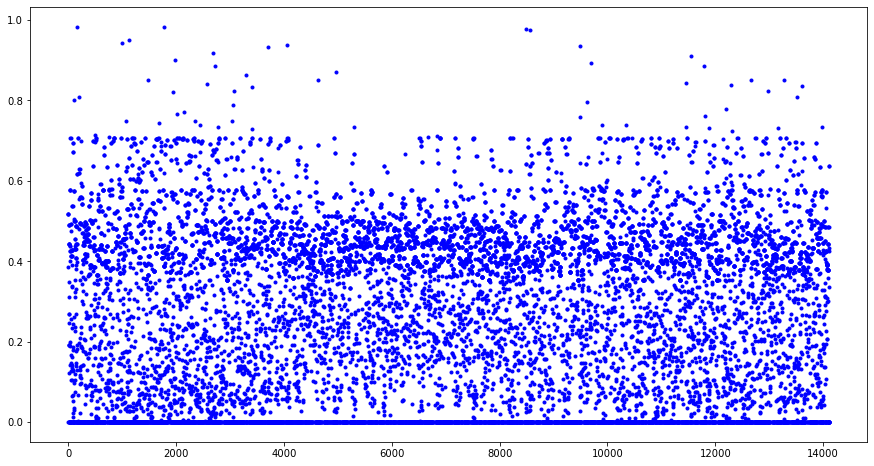

In [12]:
plt.figure(figsize=(15,8))
plt.plot(feats, 'b.')

## 3. Train a classifier with the features

For each segmentation mask, we resized it to 32x32, extracted the features using HOG and then used them to train a SVM classifier.

In [13]:
# just loading a pre-trained classifier
with open("segment_cell/clf.pkl",'rb') as file:
    clf = pickle.load(file)
clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, class_weight='balanced', gamma='auto'))])

## 4. Make predictions over the extracted masks

Text(0.5, 1.0, 'Spi prediction')

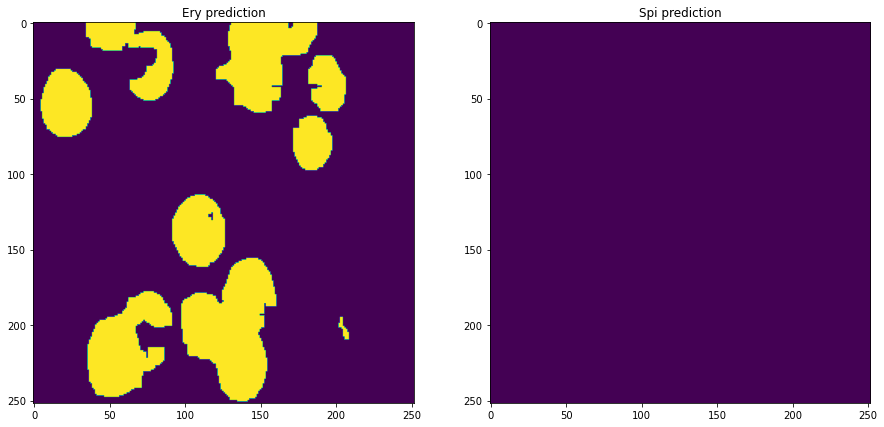

In [14]:
# get the features (labels are ignored)
feats,_,contours = get_feats_labels(image, y_pred[0], -1, return_contours=True)
    
ery_pred = np.zeros_like(y_pred[0])
spi_pred = np.zeros_like(y_pred[1])

# draw contours in the predictions
if len(feats)>0:
    class_pred = clf.predict(feats)

    for cnt, cp in zip(contours, class_pred):
        if cp==1:
            _ = cv2.drawContours(ery_pred, [cnt], 0, (255,255,255), -1)
        elif cp==2:
            _ = cv2.drawContours(spi_pred, [cnt], 0, (255,255,255), -1)

feats,_,contours = get_feats_labels(image, y_pred[1], -1, return_contours=True)
if len(feats)>0:
    class_pred = clf.predict(feats)
    for cnt, cp in zip(contours, class_pred):
        if cp==1:
            _ = cv2.drawContours(ery_pred, [cnt], 0, (255,255,255), -1)
        elif cp==2:
            _ = cv2.drawContours(spi_pred, [cnt], 0, (255,255,255), -1)
            
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(ery_pred)
plt.title('Ery prediction')
plt.subplot(122)
plt.imshow(spi_pred)
plt.title('Spi prediction')

## 5. Apply post processing in the Ery mask

Used to fill voids in the segmentation mask.

Text(0.5, 1.0, 'Post-process Spi')

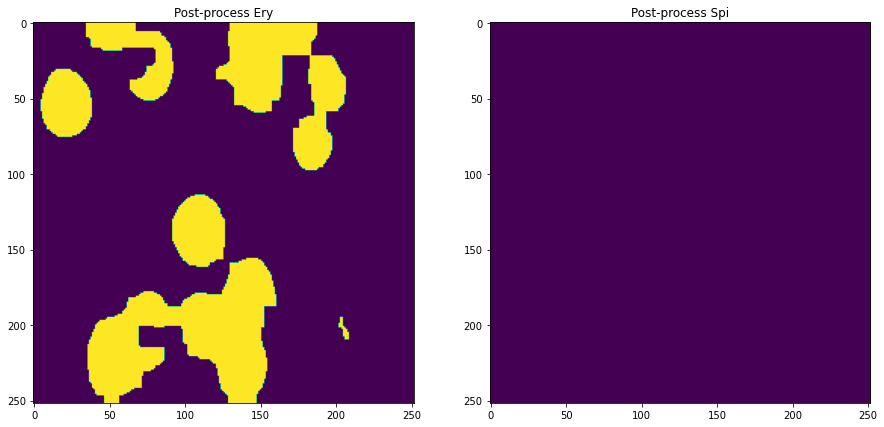

In [15]:
kernel = np.ones((5,5),np.uint8)
ery_mask = cv2.dilate(ery_pred, kernel, iterations=2)

# fill ery masks
contour = cv2.findContours(ery_mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
for cnt in contour:
    _ = cv2.drawContours(ery_mask, [cnt], -1, (255,255,255), -1)

ery_mask = cv2.erode(ery_mask, kernel, iterations=2)

spi_mask = np.copy(spi_pred)
spi_mask[ery_mask==255] = 0

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(ery_mask)
plt.title('Post-process Ery')
plt.subplot(122)
plt.imshow(spi_mask)
plt.title('Post-process Spi')

## Final result

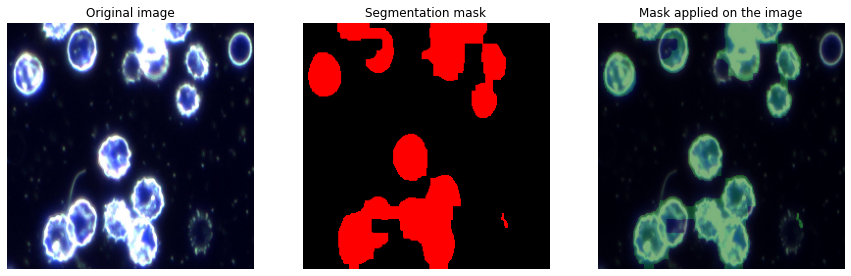

In [16]:
show_ann(image, np.stack([ery_mask, spi_mask], axis=-1))

_(optional now on...)_

## Evaluate algorithm in the test set

In [17]:
from time import time
import multiprocessing
from joblib import Parallel, delayed
NUM_CORES = multiprocessing.cpu_count()

from sklearn.metrics import classification_report, jaccard_score

In [17]:
# set data loader to the test images
data.set_data('test')

all_true, all_pred = [],[]

def make_predicts(image, mask):
    '''
    Aux function to run predictions in thread
    '''
    
    # get true masks and predicted ones
    mask_true = list(cv2.split(mask))
    mask_pred = list(predict_masks(image, clf))
    
    # post-process masks
    mask_pred = post_process(*mask_pred)
    
    # adjust values for masks
    y_true = np.where(mask_true[0]==255, 1, 0)
    y_true = np.where(mask_true[1]==255, 2, y_true)
    
    y_pred = np.where(mask_pred[0]==255, 1, 0)
    y_pred = np.where(mask_pred[1]==255, 2, y_pred)
    
    # save data
    all_true.append(y_true)
    all_pred.append(y_pred)
    
# run predictions in thread
init = time()
with Parallel(n_jobs=NUM_CORES, prefer="threads") as parallel:
    _ = parallel(delayed(make_predicts)(image, mask) \
                      for image, mask in tqdm(data, total=len(data)))
print('Elapsed time: ', time()-init)

# evaluate model
y_true = np.array(all_true).reshape(-1,1)
y_pred = np.array(all_pred).reshape(-1,1)
print(classification_report(y_true, y_pred))
print('Jaccard (macro avg): ', jaccard_score(y_true, y_pred, average='macro'))
print('Jaccard (weighted avg): ', jaccard_score(y_true, y_pred, average='weighted'))

for c in np.unique(y_true):
    
    yt = np.where(y_true==c, 1, 0)
    yp = np.where(y_pred==c, 1, 0)
    
    print(f'Jaccard {c}: ', jaccard_score(yt, yp, average='macro'))

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.09it/s]


Elapsed time:  24.48852777481079
              precision    recall  f1-score   support

           0       0.96      0.95      0.95   3866076
           1       0.71      0.77      0.74    669416
           2       0.37      0.16      0.23     36796

    accuracy                           0.92   4572288
   macro avg       0.68      0.63      0.64   4572288
weighted avg       0.92      0.92      0.91   4572288

Jaccard (macro avg):  0.5410119208567294
Jaccard (weighted avg):  0.8544997779530363
Jaccard 0:  0.7487421215484726
Jaccard 1:  0.7493164000067332
Jaccard 2:  0.5593411582728328


### Evaluate on specific images

In [33]:
path_save = '../report/results'
images = ['011', '055', '150', '250', '334']

def get_mask(mask):
    return cv2.merge([np.zeros_like(mask[...,0]), mask[...,1], mask[...,0]])

for name in images:
    img, mask = data.get_by_name(name)
    
    # get true masks and predicted ones
    mask_true = list(cv2.split(mask))
    mask_pred = list(predict_masks(img, clf))
    
    # post-process masks
    mask_pred = post_process(*mask_pred)
    mask_pred = np.stack(mask_pred, axis=-1)
    
    # save results
    cv2.imwrite(os.path.join(path_save, name+'.png'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(path_save, name+'_true.png'), get_mask(mask))
    cv2.imwrite(os.path.join(path_save, name+'_pred.png'), get_mask(mask_pred))